##Начало работы

Все используемые датасеты, данные в виде словарей и списков, сохраненные в файлах, будут находиться в папке data

#Загрузка и объединение датасетов

In [ ]:
import pandas as pd
df_1 = pd.read_csv('1976_Sep2016_USPTOgrants_smiles_yield_ok_cropped_data.csv', sep = '\t', index_col = 0)
df_2 = pd.read_csv('2001_Sep2016_USPTOapplications_smiles_yield_ok_cropped_data.csv', sep = '\t', index_col = 0)

In [ ]:
data = pd.concat([df_1, df_2])
data = data.drop_duplicates(subset=["ReactionSmiles","Yield"]) #удаление дубликатов
print(f'Размер датасета: {data.shape}')
print(f'Количество пропусков: {data.isna().sum().sum()}')
data.head()

Размер датасета: (786422, 3)
Количество пропусков: 0


,myID,ReactionSmiles,Yield
27,ID00000027,[CH2:1]([S:3][C:4]1[CH:26]=[CH:25][C:7]2[N:8](...,82.0
28,ID00000028,[CH2:1]([S:3][C:4]1[CH:25]=[CH:24][C:7]2[N:8](...,78.1
31,ID00000031,[H-].[Al+3].[Li+].[H-].[H-].[H-].[CH2:7]([S:9]...,82.1
36,ID00000036,[NH2:1][C:2]1[CH:3]=[CH:4][C:5]2[N:9]=[C:8]3[C...,67.9
41,ID00000041,[C:1]([NH:5][NH:6][C:7]([C:12]#[N:13])([CH:9]1...,81.9


В формате SMILES запись реакции происходит по типу:
"_реагент.реагент.реагент.реагент>катализатор/растворитель>продукт.продукт.продукт_"

#Распределение таргетной величины

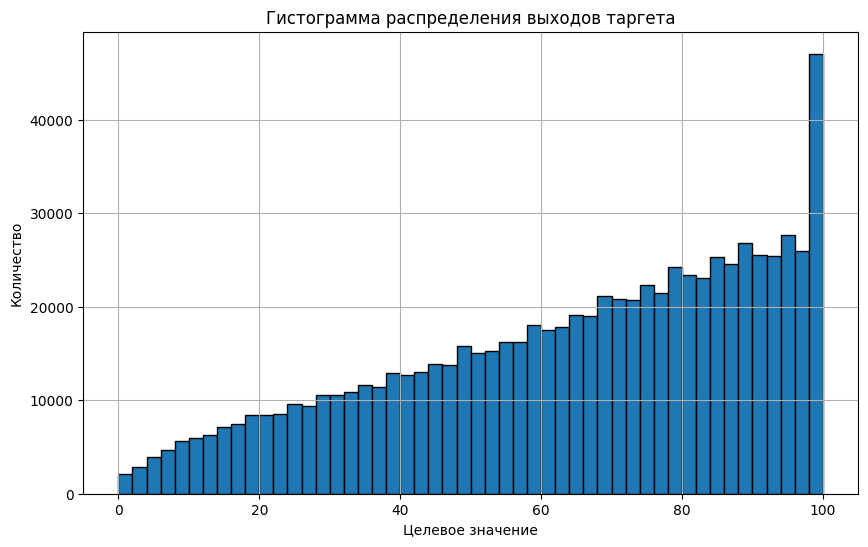

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
data['Yield'].hist(bins=50, edgecolor='black')
plt.title('Гистограмма распределения выходов таргета')
plt.xlabel('Целевое значение')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

Удаление ненужной колонки и перевод таргета из численного в категориальный тип данных

In [ ]:
def yield_category(yield_):
  if yield_ >= 70.00:
    return 1
  else:
    return 0

data['Yield'] = data['Yield'].apply(yield_category)
ds = data.drop(['myID'], axis = 1)

Удаление ненужной информации в конце реакций

In [ ]:
import re
def remove_pipe_content(input_string):
    #используем регулярное выражение для удаления содержимого между '|'
    return re.sub(r' \|.*?\|', '', input_string)

ds['ReactionSmiles'] = ds['ReactionSmiles'].apply(remove_pipe_content)

#Анализ количества продуктов в реакциях

In [ ]:
def splitting(string):
  list1 = str(string).split('>') #разделяем строку на реагенты, катализаторы/растворители, продукты
  return list1[-1] #возвращаем только продукты

ds['product'] = ds['ReactionSmiles'].apply(splitting)

def counter(string):
  list1 = str(string).split('.')
  return len(list1)

ds['count_product'] = ds['product'].apply(counter)
ds['count_product'].value_counts()

,count
count_product,
1,747730
2,32064
3,5454
4,861
5,215
7,35
6,33
9,10
11,8


Оставляем реакции органического синтеза (только один продукт)

In [ ]:
ds = ds[ds['count_product'] == 1]
ds = ds.drop(['product', 'count_product'], axis = 1) #удаляем лишние колонки

#Финальное распределение таргетной величины

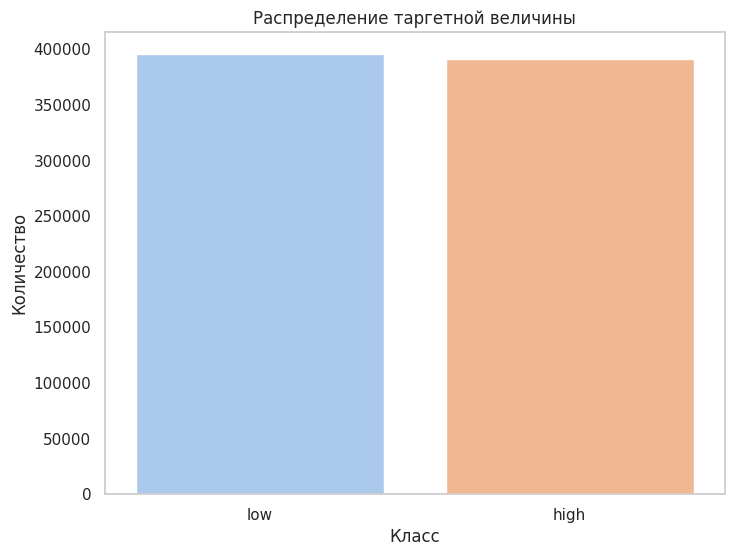

In [ ]:
import seaborn as sns

sns.set(style="whitegrid")

#построение графика распределения
plt.figure(figsize=(8, 6))
sns.countplot(x=data['Yield'], palette='pastel', hue=data['Yield'], legend = False)
plt.title('Распределение таргетной величины')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks(ticks=[0, 1], labels=['low', 'high'])
plt.grid(axis='y')
plt.show()

In [ ]:
print(f'Количество реакций с низким выходом: {len(ds[ds["Yield"]==0])}\nКоличество реакций с высоким выходом: {len(ds[ds["Yield"]==1])}')

Количество реакций с низким выходом: 378319
Количество реакций с высоким выходом: 369411


Сохраняем датасет

In [ ]:
ds.to_csv('prepared_data.csv', sep = '\t')

Теперь необходимо перевести все химические реакции из формата SMILES в текстовый вид. Для экономии времени и ресурсов я решил создать список уникальных молекул датасета, а затем из него сделать словарь с ключами в виде молекул формата SMILES, а значениями этих ключей будет текстовое наименование молекул по номенклатуре ИЮПАК.

#Создание списка уникальных молекул

In [ ]:
from tqdm.auto import tqdm
import json
new_list = set() #использую множество, чтобы не проверять каждый раз в цикле функции отсутствие молекулы в списке
tqdm.pandas()

def unique(input):
    listt = input.replace('>', '.').split('.')
    for i in listt:
      new_list.add(i)
    return input

ds['ReactionSmiles'] = ds['ReactionSmiles'].progress_apply(unique)

new_list = list(new_list)

print(f'Количество уникальных молекул: {len(new_list)}')

with open('unique_mol_list.json', 'w') as file:
    json.dump(new_list, file)

  0%|          | 0/747730 [00:00<?, ?it/s]

Количество уникальных молекул: 1549153


Теперь необходимо создать словарь с ключ-молекула SMILES : значение-текстовое название молекулы по ИЮПАК. Так как генерация названия молекул - очень времязатратный и ресурсозатратный процесс, я выполнял его на кластерном сервере, на который можно загружать только .py файлы. Продолжение в 2_dict_SMILES_text.py